In [44]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict

In [98]:
df = pd.read_csv('data/flight_traffic.csv') 
df.head()

,year,month,day,airline_id,origin_airport,destination_airport,scheduled_departure,actual_departure,taxi_out,wheels_off,...,cancelled,diverted,scheduled_elapsed,actual_elapsed,distance,airline_delay,weather_delay,air_system_delay,security_delay,aircraft_delay
0,2017,1,17,AA,CLT,PHX,1619,1616.0,17.0,1633.0,...,0.0,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN
1,2017,1,18,AA,CLT,PHX,1619,1614.0,13.0,1627.0,...,0.0,0.0,277.0,247.0,1773.0,NaN,NaN,NaN,NaN,NaN
2,2017,1,19,AA,CLT,PHX,1619,1611.0,17.0,1628.0,...,0.0,0.0,277.0,255.0,1773.0,NaN,NaN,NaN,NaN,NaN
3,2017,1,20,AA,CLT,PHX,1619,1656.0,18.0,1714.0,...,0.0,0.0,277.0,273.0,1773.0,33.0,0.0,0.0,0.0,0.0
4,2017,1,21,AA,CLT,PHX,1619,1632.0,17.0,1649.0,...,0.0,0.0,277.0,266.0,1773.0,NaN,NaN,NaN,NaN,NaN


In [90]:
def convertDateToMinutes(t):
    t = int(t)
    hours = (t/100) % 100
    minutes = t % 100
    return 60*hours + minutes
def getTimeDifference(t1, t2):
    totalMin = 24*60
    t1 = convertDateToMinutes(t1)
    t2 = convertDateToMinutes(t2)
    if t1 > t2 and t1 - t2 < 60: # early departure
        return t2 - t1
    return (t2 - t1) % totalMin

In [171]:
print getTimeDifference(510, 1510)
print getTimeDifference(2230, 130)
print getTimeDifference(600, 555)

600
180
-5


In [147]:
def process(df):
    df = df[df['scheduled_departure'].notnull()]
    df = df[df['actual_departure'].notnull()]
    df = df[df['scheduled_arrival'].notnull()]
    df = df[df['actual_arrival'].notnull()]
    df = df[df['scheduled_elapsed'].notnull()]
    df = df[df['actual_elapsed'].notnull()]
    df.loc[:,'dep_diff'] = df.apply(lambda row: getTimeDifference(row['scheduled_departure'], row['actual_departure']), axis=1)
    df.loc[:,'arr_diff'] = df.apply(lambda row: getTimeDifference(row['scheduled_arrival'], row['actual_arrival']), axis=1)
    df.loc[:,'elapsed_diff'] = df['actual_elapsed'] - df['scheduled_elapsed']
    return df

In [178]:
def plot_delay_times(series):
    big_five = ['AA', 'B6', 'DL', 'UA', 'WN']
    airline_map = {}
    for key, val in series.iteritems():
        if key[0] not in big_five:
            continue
        if key[0] not in airline_map:
            airline_map[key[0]] = []
        airline_map[key[0]].append(val)

    for airline, val in airline_map.iteritems():
        plt.plot(np.arange(0, len(val)), val, label=airline)
        plt.xlabel('day of year')
        plt.ylabel('average delay')

    plt.legend()
    plt.show()

In [173]:
nyc_df = df[df['origin_airport'].isin(['JFK', 'LGA', 'EWR'])]
nyc_df = process(nyc_df)

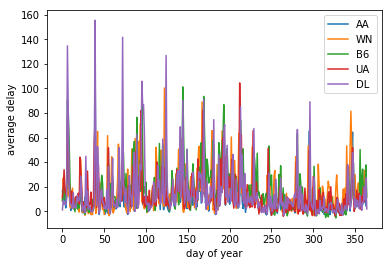

In [179]:
nyc_group = nyc_df.groupby(['airline_id', 'year', 'month', 'day'])['dep_diff'].mean()
plot_delay_times(nyc_group)

In [175]:
sf_df = df[df['origin_airport'].isin(['SFO', 'SJC', 'OAK'])]
sf_df = process(sf_df)

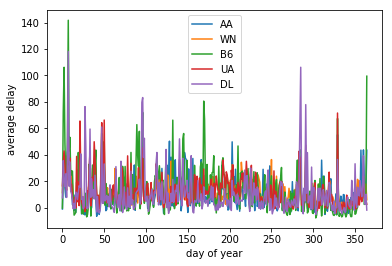

In [180]:
sf_group = sf_df.groupby(['airline_id', 'year', 'month', 'day'])['dep_diff'].mean()
plot_delay_times(sf_group)